# ATE estimations from real observational data
*This notebook examines the use of Bayesian Networks for estimating Average Treatment Effects (ATE) in Observational Studies within the Neyman-Rubin potential outcome framework from real data:* 

In [23]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.skbn as skbn
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

pd.set_option('future.no_silent_downcasting', True)

### Dataset
The dataset under consideration is the Census Adult Income dataset.
The objective of this analysis is to determine whether possessing a graduate degree increases the likelihood of earning an income exceeding $50,000 per year.

In [72]:
df = pd.read_pickle("../data/df_causal_discovery.p")
df.head()

,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
0,39,40,0,0,1,0,0
1,50,13,0,1,1,0,0
2,38,40,0,0,1,0,0
3,53,40,0,1,0,0,0
5,37,40,1,0,1,1,0


In [73]:
df.describe()

,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
count,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000
mean,38.655674,40.447755,0.052348,0.406616,0.878334,0.331916,0.245835
std,13.722408,12.417203,0.222732,0.491211,0.326905,0.470909,0.430588
min,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,40.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,40.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,45.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,90.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Bayesian Network Preparation
We begin by focusing exclusively on the age covariate to inform our estimations. We hypothesize that age is a causal factor influencing both the hasGraduateDegree variable and the greaterThan50k outcome.

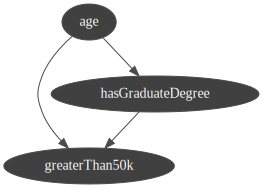

In [74]:
disc = skbn.BNDiscretizer(defaultDiscretizationMethod="NoDiscretization", defaultNumberOfBins=None)
template = disc.discretizedBN(df[["age", "hasGraduateDegree", "greaterThan50k"]])
template.addArcs([("age","hasGraduateDegree"), ("age", "greaterThan50k"), ("hasGraduateDegree", "greaterThan50k")])

gnb.show(template, size="50")

In [75]:
p_learner = gum.BNLearner(df, template)
p_learner.useNMLCorrection()
p_learner.useSmoothingPrior(1e-9)

bn = gum.BayesNet(template)
p_learner.fitParameters(bn)

print(p_learner)

Filename       : /tmp/tmp9oipz0_e.csv
Size           : (29170,3)
Variables      : age[73], hasGraduateDegree[2], greaterThan50k[2]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000



In [76]:
cbn = csl.CausalModel(bn)

T = "hasGraduateDegree"
Y = "greaterThan50k"
X = "age"

In [78]:
cslnb.showCausalImpact(cbn, on=Y, doing=T, values={T:1}) 

$$\begin{equation*}P( greaterThan50k \mid \text{do}(hasGraduateDegree)) = \sum_{age}{P\left(greaterThan50k\mid age,hasGraduateDegree\right) \cdot P\left(age\right)}\end{equation*}$$

In [10]:
_,cpt0,_ = csl.causalImpact(cbn, on=Y, doing=T, knowing={X}, values={T:0})
_,cpt1,_ = csl.causalImpact(cbn, on=Y, doing=T, knowing={X}, values={T:1})

CATE = (cpt1 - cpt0).topandas()
CATE = CATE[Y]["1"]

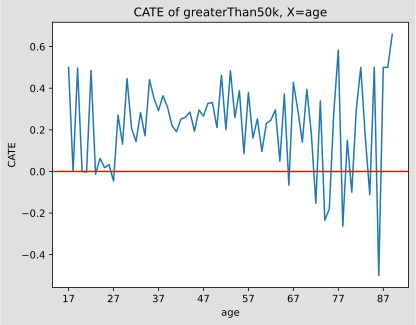

In [11]:
plt.plot(CATE)

plt.xticks(np.arange(0, 80, 10))
plt.axhline(y=0, color="r")
plt.title("CATE of greaterThan50k, X=age")
plt.xlabel("age")
plt.ylabel("CATE")
plt.show()

In [45]:
density = gaussian_kde(pd.cut(CATE.values, bins=10).value_counts())
xs = np.linspace(-0.5,0.7,200)

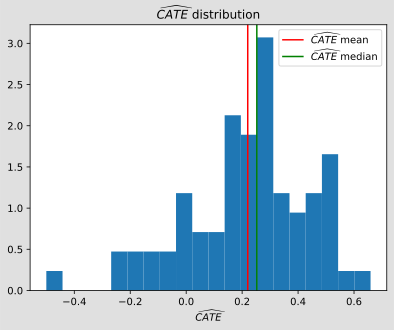

In [63]:
plt.hist(x=CATE, density=True, bins=20)
#plt.plot(xs, density(xs))

plt.xlabel("$\widehat{CATE}$")
plt.title("$\widehat{CATE}$ distribution")
plt.axvline(x=CATE.mean(), color="red", label="$\widehat{CATE}$ mean")
plt.axvline(x=CATE.median(), color="green", label="$\widehat{CATE}$ median")
plt.legend()
plt.show()

In [64]:
def mutilateBN(bn : gum.BayesNet) -> gum.BayesNet:
    """
    Returns a copy of the Bayesian Network with all incoming arcs to the variable T removed.
    """
    res = gum.BayesNet(bn)
    for p_id in bn.parents(T):
        res.eraseArc(p_id, bn.idFromName(T))
    return res

def ATE(bn, X = {}, mutilate = True):
    ie = gum.LazyPropagation(mutilateBN(bn)) if mutilate else gum.LazyPropagation(bn)

    ie.setEvidence({T: 0} | X)
    ie.makeInference()
    p0 = ie.posterior(Y)

    ie.chgEvidence(T,1)
    ie.makeInference()
    p1 = ie.posterior(Y)

    diff = p1 - p0
    return diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))

In [65]:
ATE(bn)

0.2332334047559898

Let's examine whether incorporating all available covariates influences the estimation of the ATE. We will employ structure learning techniques to determine the DAG that the algorithm identifies from the data.

In [79]:
disc = skbn.BNDiscretizer(defaultNumberOfBins=5, defaultDiscretizationMethod="uniform")
template = disc.discretizedBN(df)

Filename       : /tmp/tmpuny3jv0f.csv
Size           : (29170,7)
Variables      : age[5], hours-per-week[5], hasGraduateDegree[2], inRelationship[2], isWhite[2], isFemale[2], greaterThan50k[2]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000001



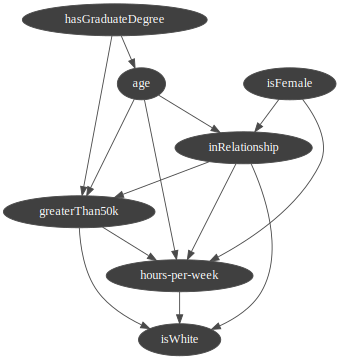

In [81]:
s_learner = gum.BNLearner(df, template)
s_learner.useNMLCorrection()
s_learner.useSmoothingPrior(1e-6)

bn2 = s_learner.learnBN()

print(s_learner)

gnb.showBN(bn2)

In [82]:
cbn2 = csl.CausalModel(bn2)

In [83]:
cslnb.showCausalImpact(cbn2, on=Y, doing=T, values={T:1}) 

In [71]:
ATE(bn2)

0.32517711710620006

We observe a higher estimated Average Treatment Effect (ATE) when incorporating all covariates compared to the estimation that accounts only for the `age` covariate.